In [22]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pickle
import timeit
import aesara.tensor as at
from arviz.plots import plot_utils as azpu
import pandas as pd
import decimal
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import arviz as az
import matplotlib.gridspec as gridspec

from pymc import HalfCauchy, Model, Normal,sample, Uniform
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v5.17.0


In [23]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


In [24]:
with open('data_c1.pickle', 'rb') as f:
    
   beta_val,K_val,n_val,a1_val,beta1_val,K1_val,n1_val,K2_val,n2_val, a2_val, a3_val,k,x1_0,x2_0,x3_0,fT,t_ori,X1_ssa,X2_ssa,X3_ssa = pickle.load(f)

dt  =t_ori[1]-t_ori[0]
n_seq = len(t_ori)

beta_val,K_val,n_val,a1_val,beta1_val,K1_val,n1_val,K2_val,n2_val, a2_val, a3_val,k

#/Users/anshigupta/3D System/data_ex2.pickle'

(10, 70, 2, 0.03, 20, 10, 2, 50, 2, 0.01, 0.05, 3)

In [25]:
def return_data(n_data,type_data,t_last):
    # This function is only for bring the data.
    x1_ssa = X1_ssa
    x2_ssa = X2_ssa
    x3_ssa =  X3_ssa
    if type_data == 'ssa':
        x1 = x1_ssa.copy()
        x2 = x2_ssa.copy()
        x3 = x3_ssa.copy()
    XX1 = x1[:-1]
    dXX1 = x1[1:]- x1[:-1]
    XX2 = x2[:-1]
    dXX2 = x2[1:]- x2[:-1]
    XX3 = x3[:-1]
    dXX3 = x3[1:]- x3[:-1]
    
    return XX1[:t_last], dXX1[:t_last], XX2[:t_last], dXX2[:t_last],XX3[:t_last], dXX3[:t_last]

3999
[-1. -1.  0. ... -1.  0.  1.]
[ 1.  1. -1. ...  0.  0.  0.]
[ 2. -1.  1. ... -3. -3. -1.]


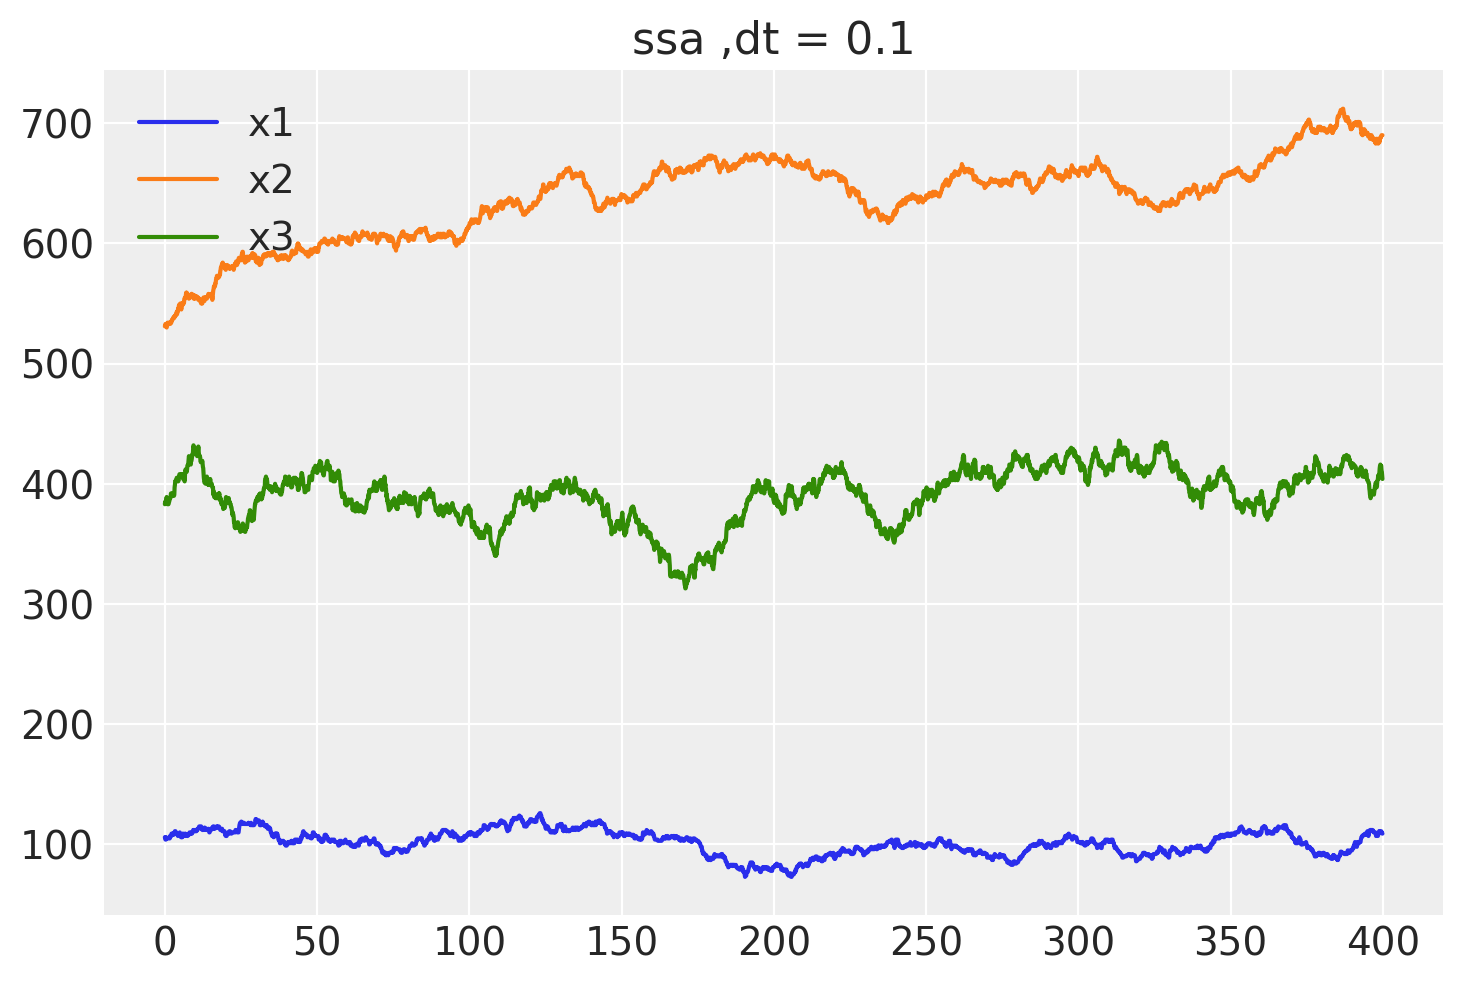

In [41]:
Type_data = ['ssa']
n_type = 0

# decide length of trajectory 
t_last = 3999

# decide dt
DT= [0.1]
n_dt = 0 

# which trajectories will be used. 
n_data = 0

type_data = Type_data[n_type]
dt = DT[n_dt]

XX1, dXX1, XX2, dXX2,XX3,dXX3 = return_data(n_data,type_data,t_last)

plt.plot(t_ori[:t_last],XX1,label = 'x1')
plt.plot(t_ori[:t_last], XX2, label = 'x2')
plt.plot(t_ori[:t_last], XX3, label = 'x3')
plt.title(type_data+' ,dt = %s' %dt)
plt.legend()
len(t_ori[:t_last])
print(len(XX1))
print(dXX1)
print(dXX2)
print(dXX3)

In [42]:
def regularized_horseshoe(prefix, nu_l=1, sigma_l=1, nu_tau=1, sigma_tau=0.1, alpha_c=0.5*4, beta_c=0.5*4):
    l = pm.HalfStudentT(f'{prefix}_l', nu=nu_l, sigma=sigma_l)
    tau = pm.HalfStudentT(f'{prefix}_tau', nu=nu_tau, sigma=sigma_tau)
    c = pm.InverseGamma(f'{prefix}_c', alpha=alpha_c, beta=beta_c)
    lt = pm.Deterministic(f'{prefix}_lt', pm.math.sqrt(c) * l / pm.math.sqrt(c + pm.math.sqr(tau) * pm.math.sqr(l)))
    z = pm.Normal(f'{prefix}_z', mu=0, sigma=1)
    beta = pm.Deterministic(f'{prefix}', z * tau * lt)
    return beta

F1=dt*(beta1*(x2t**n)/(x2t**n + K**n) + beta2*(K**n)/(x2t**n + K**n)+
               beta3*(x3t**n1)/(x3t**n1 + K1**n1) + beta4*(K1**n1)/(x3t**n1+ K1**n1)+
               beta5*(pow(x2t,n)*pow(x3t,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1)))+
               beta6*(pow(K,n)*pow(x3t,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1)))+
               beta7*(pow(x2t,n)*pow(K1,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1)))+
               beta8*(pow(K,n)*pow(K1,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1)))
              - a1*x1t)
 G1 = pm.math.sqrt(dt)*(pm.math.sqrt(pm.math.abs(beta1*(x2t**n)/(x2t**n + K**n))
                                            +pm.math.abs( beta2*(K**n)/(x2t**n + K**n))
                                             +pm.math.abs(beta3*(x3t**n1)/(x3t**n1 + K1**n1))
                                             +pm.math.abs(beta4*(K1**n1)/(x3t**n1+ K1**n1))
                                             +pm.math.abs(beta5*(pow(x2t,n)*pow(x3t,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1))))
                                             +pm.math.abs( beta6*(pow(K,n)*pow(x3t,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1))))
                                             +pm.math.abs( beta7*(pow(x2t,n)*pow(K1,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1))))
                                             +pm.math.abs( beta8*(pow(K,n)*pow(K1,n1))/((pow(x1t,n)+pow(K,n))*(pow(x2t,n1)+pow(K1,n1))))
                                            + pm.math.abs(a1*x1t) ))

def mcmc_model_cle(x1t,x2t,x3t, dx1t, dx2t,dx3t, dt):
    with pm.Model() as model:
        
      
        beta1 = regularized_horseshoe('beta1')
        beta2 = regularized_horseshoe('beta2')
        beta3 = regularized_horseshoe('beta3')
        #beta1=pm.Exponential("beta1", 0.5)
        #beta2=pm.Exponential("beta2", 0.5)
        #beta3=pm.Exponential("beta3", 0.5)
        p=pm.Beta("p",alpha=1/2,beta=1/2)
        theta1=pm.Bernoulli("theta1",p=p)
        theta2=pm.Bernoulli("theta2",p=p)
        theta3=pm.Bernoulli("theta3",p=p)
        theta4=pm.Bernoulli("theta4",p=p)
        delta=pm.Bernoulli("delta",p=p)

        #theta1=pm.Bernoulli("theta1",p=0.5)
        #theta2=pm.Bernoulli("theta2",p=0.5)
        #theta3=pm.Bernoulli("theta3",p=0.5)
        #theta4=pm.Bernoulli("theta4",p=0.5)
        #delta=pm.Bernoulli("delta",p=0.5)
        beta21=20
        beta22=0
        beta23=0
        beta24=0
        #beta21 = regularized_horseshoe("beta21", 0.5)
        #beta22 = regularized_horseshoe("beta22", 0.5)
        #beta23 = regularized_horseshoe("beta23", 0.5)
        #beta24 = regularized_horseshoe("beta24", 0.5)
        
        
        #Kr=pm.Gamma("Kr",alpha=320,beta=10)
        K = K_val
        K1=K1_val
        K2=K2_val
        n = n_val
        n1=n1_val
        n2=n2_val
        a1 = pm.HalfNormal("a1", sigma=4)
        a2 = pm.HalfNormal("a2", sigma=4)
        a3 = pm.HalfNormal("a3", sigma=4)
        r1=3
        r2=0
        r3=0
   
        
        
        #delta=pm.Bernoulli("delta",p=0.5)   
        
        F1=dt*(r1- a1*x1t)
        F2 = dt * (delta*(
            beta1 * (
        (theta1 * x1t**n1 + (1 - theta1) * K**n1) / (x1t**n1 + K**n1)) +
            beta2 * (
        (theta2 * x3t**n2 + (1 - theta2) * K2**n2) / (x3t**n2 + K2**n2)
        ) )+
        (1-delta)*(beta3 * (
        (theta3 * theta4 * (x1t**n) * (x3t**n2)) +
        (theta3 * (1 - theta4) * (x1t**n) * (K2**n2)) +
        ((1 - theta3) * theta4 * (K**n) * (x3t**n2)) +
        ((1 - theta3) * (1 - theta4) * (K**n) * (K2**n2))
         ) / (
        (K**n + x1t**n) * (K2**n2 + x3t**n2)
            )) -
            a2 * x2t
        )


        
        F3 = dt * (
        
        beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))
        
        -a3 * x3t+r3)

        G1 = pm.math.sqrt(dt)*pm.math.sqrt(pm.math.abs(r1)
                                            + pm.math.abs(a1*x1t) )


        G2 = pm.math.sqrt(dt) * (
        pm.math.sqrt(
        delta * (
            pm.math.abs(beta1 * (
                (theta1 * x1t**n1 + (1 - theta1) * K**n1) / (x1t**n1 + K**n1)
            )) +
            pm.math.abs(beta2 * (
                (theta2 * x3t**n2 + (1 - theta2) * K2**n2) / (x3t**n2 + K2**n2)
            ))
        ) +
        (1 - delta) * (
            pm.math.abs(
                beta3 * (
                    (theta3 * theta4 * (x1t**n) * (x3t**n2)) +
                    (theta3 * (1 - theta4) * (x1t**n) * (K2**n2)) +
                    ((1 - theta3) * theta4 * (K**n) * (x3t**n2)) +
                    ((1 - theta3) * (1 - theta4) * (K**n) * (K2**n2))
                ) / (
                    (K**n + x1t**n) * (K2**n2 + x3t**n2)
                )
            ) +
            pm.math.abs(a2 * x2t) + pm.math.abs(r2)
            )
        )
        )



       
        

        G3= pm.math.sqrt(dt) * (
        pm.math.sqrt(
       
            pm.math.abs( beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs( beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs(beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs(  beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2))))+
        
        pm.math.abs(a3 * x3t)+pm.math.abs(r3)))
        
        
        
        mu1 = F1
        mu2 = F2
        mu3 = F3
        sig1 = G1
        sig2 = G2
        sig3 = G3
        
        likelihood1 = pm.Normal("obs1", mu=mu1, sigma=sig1, observed=dx1t)
        likelihood2 = pm.Normal("obs2", mu=mu2, sigma=sig2, observed=dx2t)
        likelihood3 = pm.Normal("obs3", mu=mu3, sigma=sig3, observed=dx3t)
        step = pm.step_methods.hmc.nuts.NUTS(target_accept  = 0.9)
        trace = sample(10000,step = step, return_inferencedata=True,tune=5000,chains=4)
        
        return trace

       


In [54]:

def mcmc_model_cle(x1t,x2t,x3t, dx1t, dx2t,dx3t, dt):
    with pm.Model() as model:
        
        beta9 = regularized_horseshoe("beta9", 0.5)
        beta10 = regularized_horseshoe("beta10", 0.5)
        
        beta21 = regularized_horseshoe("beta21", 0.5)
        beta22 = regularized_horseshoe("beta22", 0.5)
        beta23 = regularized_horseshoe("beta23", 0.5)
        beta24 = regularized_horseshoe("beta24", 0.5)
        
        
      
        #beta9 = pm.Exponential("beta9", 0.5)
        #beta10 = pm.Exponential("beta10", 0.5)
        
        #beta21 = pm.Exponential("beta21", 0.5)
        #beta22 = pm.Exponential("beta22", 0.5)
        #beta23 = pm.Exponential("beta23", 0.5)
        #beta24 = pm.Exponential("beta24", 0.5)
        
                
        #Kr=pm.Gamma("Kr",alpha=320,beta=10)
        K = K_val
        K1=K1_val
        K2=K2_val
        n = n_val
        n1=n1_val
        n2=n2_val
        a1 = pm.HalfNormal("a1", sigma=4)
        a2 = pm.HalfNormal("a2", sigma=4)
        a3 = pm.HalfNormal("a3", sigma=4)
        r1=3
        r2=0
        r3=0
        
        F1=dt*(r1- a1*x1t)
        F2 = dt * (
        beta9 * (x1t**n) / (x1t**n + K**n) + 
        beta10 * (K**n) / (x1t**n + K**n) 
                   
        -a2 * x2t+r2)

        F3 = dt * (
        
        beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))
        
        -a3 * x3t+r3)

        G1 = pm.math.sqrt(dt)*pm.math.sqrt(pm.math.abs(r1)
                                            + pm.math.abs(a1*x1t) )

        G2= pm.math.sqrt(dt) * (
        pm.math.sqrt(
        pm.math.abs(beta9 * (x1t**n) / (x1t**n + K**n))
        +pm.math.abs( beta10 * (K**n) / (x1t**n + K**n))
          +pm.math.abs(a2 * x2t)+pm.math.abs(r2)))

        G3= pm.math.sqrt(dt) * (
        pm.math.sqrt(
       
            pm.math.abs( beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs( beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs(beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs(  beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2))))+
        
        pm.math.abs(a3 * x3t)+pm.math.abs(r3)))

        
        
        mu1 = F1
        mu2 = F2
        mu3 = F3
        sig1 = G1
        sig2 = G2
        sig3 = G3
        
        likelihood1 = pm.Normal("obs1", mu=mu1, sigma=sig1, observed=dx1t)
        likelihood2 = pm.Normal("obs2", mu=mu2, sigma=sig2, observed=dx2t)
        likelihood3 = pm.Normal("obs3", mu=mu3, sigma=sig3, observed=dx3t)
        step = pm.step_methods.hmc.nuts.NUTS(target_accept  = 0.9)
        trace = sample(10000,step = step, return_inferencedata=True,tune=5000,chains=4)
        
        return trace



In [ ]:
trace_cle = mcmc_model_cle(XX1, XX2,XX3,dXX1, dXX2,dXX3 ,dt)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta9_l, beta9_tau, beta9_c, beta9_z, beta10_l, beta10_tau, beta10_c, beta10_z, beta21_l, beta21_tau, beta21_c, beta21_z, beta22_l, beta22_tau, beta22_c, beta22_z, beta23_l, beta23_tau, beta23_c, beta23_z, beta24_l, beta24_tau, beta24_c, beta24_z, a1, a2, a3]


Output()

In [51]:
print(np.isnan(XX2).sum())
print(np.isinf(XX2).sum())  


0
0


array([[<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
        <Axes: title={'center': 'a3'}>]], dtype=object)

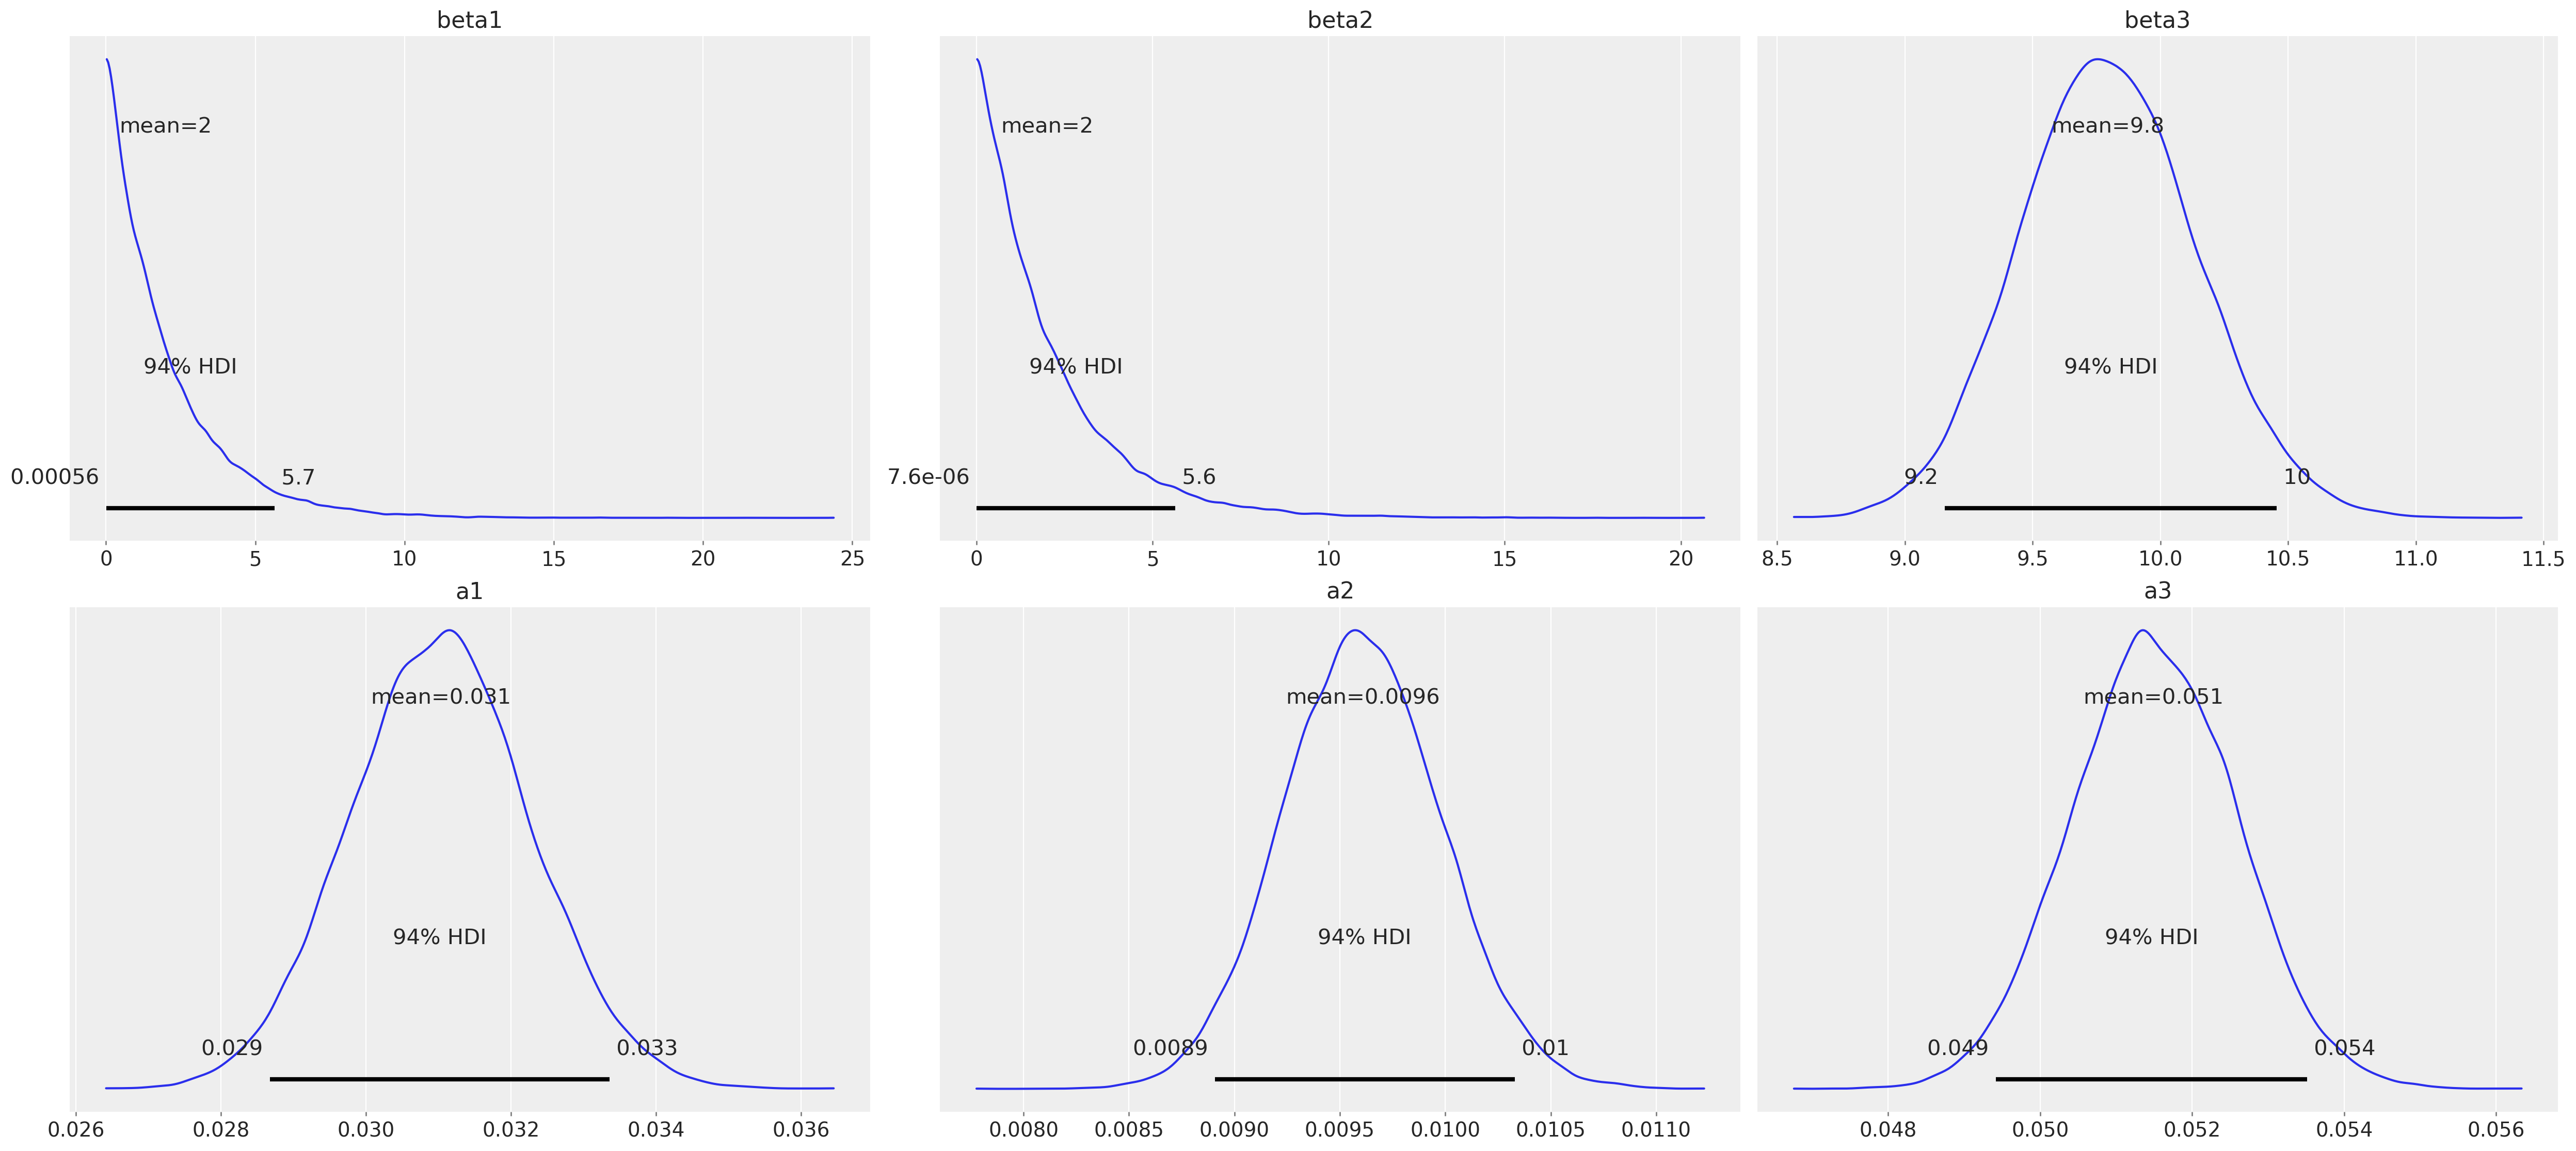

In [38]:
#az.plot_trace(trace_cle)
betas=['beta1','beta2','beta3','a1','a2','a3']
trace_cle.posterior[betas].values
az.plot_posterior(trace_cle, var_names=betas)

In [55]:
trace_cle.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables: (12/19)
    a1       (chain, draw) float64 0.02797 0.0302 0.02908 ... 0.0271 0.03089
    a2       (chain, draw) float64 0.04185 0.04059 0.04254 ... 0.04233 0.04255
    a3       (chain, draw) float64 0.06178 0.06001 0.06239 ... 0.06237 0.0613
    beta10   (chain, draw) float64 2.365 2.199 0.1457 ... 3.953 4.51 0.8809
    beta11   (chain, draw) float64 9.038 5.276 10.67 5.129 ... 12.9 13.7 3.752
    beta12   (chain, draw) float64 1.99 2.439 2.541 ... 0.08165 0.1043 0.006406
    ...       ...
    beta20   (chain, draw) float64 2.577 1.442 0.2917 ... 0.3434 0.3505 6.291
    beta21   (chain, draw) float64 5.321 1.503 8.532 ... 5.633 6.688 0.9962
    beta22   (chain, draw) float64 3.147 1.158 1.143 3.226 ... 1.578 1.12 3.597
    beta23   (chain, draw) float64 2.867 1.118 2.881 ... 0.3119 0.3695 5.916
    beta24   (chain, draw) float64 1.378 0.6331 3.103 ... 2.154 1.505 2.476
    beta9    (chain, draw) float64 7.834 6.773 6.849 12.8 ... 1.007 1.154 10.47
Attributes:
    created_at:                 2024-09-10T00:17:18.958208+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0
    sampling_time:              12726.422794818878
    tuning_steps:               5000

In [39]:
def analysis_CLE(trace, true_values):
    #colume = list(trace.posterior.data_vars)
    colume = ['beta1','beta2','beta3','a1','a2','a3','delta','theta1','theta2','theta3','theta4']
    Mean = []
    Mode = []
    Sd = []
    Samples = []
    tune = 3000
    
    # Check if the length of true_values matches the e columns
    if len(true_values) != len(colume):
        raise ValueError("Length of true_values must match the length of 'colume'")
    
    for name in colume:
        Mean.append(az.summary(trace, kind="stats")['mean'][name])
        Sd.append(az.summary(trace, kind="stats")['sd'][name])
        
        sam = []
        for i in range(4):
            samples = trace.posterior[name][i][tune:]
            sam.append(samples)
        
        sam = np.array(sam).flatten()
        Samples.append(sam)
        
        counts, left = np.histogram(sam, bins=10000)
        l_max = np.argmax(counts)
        Mode.append((left[l_max] + left[l_max+1]) / 2)

    # Create the DataFrame for true values
    table = pd.DataFrame(index=colume, data=np.vstack([true_values, Mode, Mean, Sd]).T, columns=['true', 'mode', 'mean', 'std'])
    
    print(table)


In [40]:
true_values=[10,0,20,0.03,0.01,0.05,1,1,1,1,1]
analysis_CLE(trace_cle,true_values)

         true      mode   mean    std
beta1   10.00  0.004219  1.994  2.019
beta2    0.00  0.160781  2.002  2.005
beta3   20.00  9.843786  9.795  0.346
a1       0.03  0.031057  0.031  0.001
a2       0.01  0.009538  0.010  0.000
a3       0.05  0.051978  0.051  0.001
delta    1.00  0.000050  0.000  0.000
theta1   1.00  0.000050  0.500  0.500
theta2   1.00  0.000050  0.499  0.500
theta3   1.00  1.000050  1.000  0.000
theta4   1.00  1.000050  1.000  0.000


In [32]:
trace=trace_cle

array([[<Axes: title={'center': 'beta9'}>,
        <Axes: title={'center': 'beta10'}>,
        <Axes: title={'center': 'beta21'}>],
       [<Axes: title={'center': 'beta22'}>,
        <Axes: title={'center': 'beta23'}>,
        <Axes: title={'center': 'beta24'}>]], dtype=object)

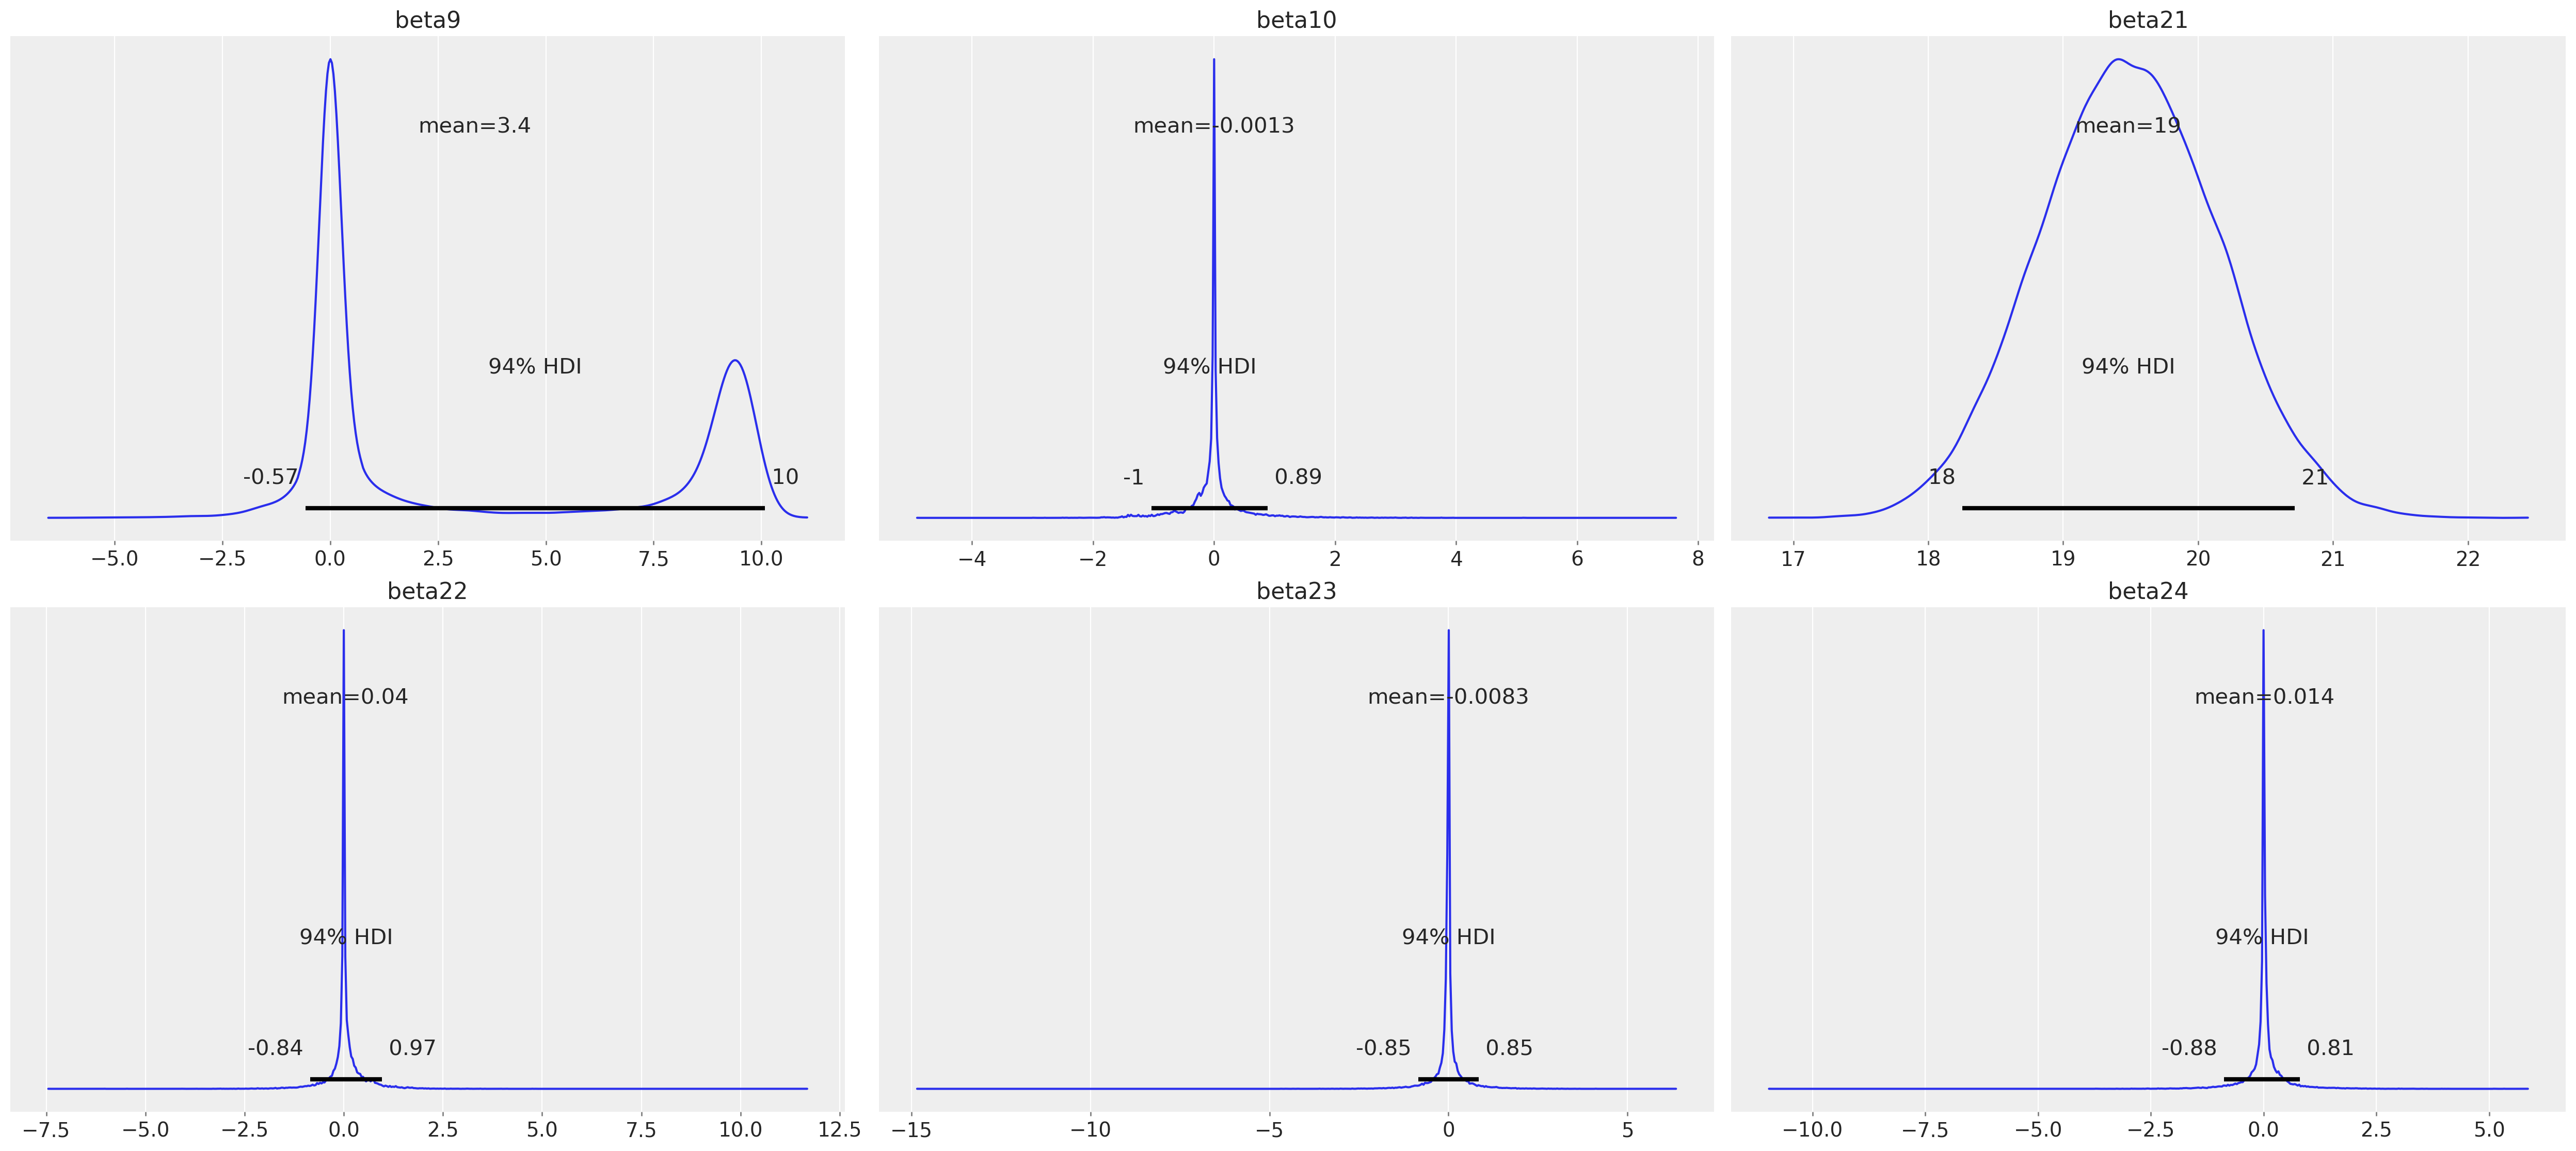

In [33]:
betas=['beta9','beta10','beta21','beta22','beta23','beta24']
trace.posterior[betas].values
az.plot_posterior(trace, var_names=betas)

In [35]:
p0=0.9
pruned_parameters = {}
all_scale_samples = []

# Loop over beta parameters dynamically
for param in trace_cle.posterior.keys():
    if param.startswith('beta') and param.endswith('_tau'):
        # Extract the index from the parameter name (e.g., 'beta1_tau' -> '1')
        i = param.split('_')[0].replace('beta', '')
        
        tau_samples = trace_cle.posterior[f'beta{i}_tau'].values.flatten()
        l_samples = trace_cle.posterior[f'beta{i}_l'].values.flatten()
        z_samples = trace_cle.posterior[f'beta{i}_z'].values.flatten()
        
        scale_samples = tau_samples * l_samples * z_samples
        all_scale_samples.extend(scale_samples)
        
        mean_scale = np.mean(all_scale_samples)
        delta = 0.1 * mean_scale  # 10% of the mean scale
        
        prune_probs = np.mean(scale_samples < np.abs(delta))
        
        # Decide if the parameter should be pruned
        prune_decision = prune_probs > p0
        pruned_parameters[f'beta{i}'] = prune_decision
        
        # Debugging information
        print(f"beta{i}: prune_probs = {prune_probs:.2f}, prune_decision = {prune_decision}")
        
        if prune_decision:
            print(f"Parameter beta{i} should be pruned")



beta10: prune_probs = 0.89, prune_decision = False
beta11: prune_probs = 0.54, prune_decision = False
beta12: prune_probs = 0.98, prune_decision = True
Parameter beta12 should be pruned
beta13: prune_probs = 0.74, prune_decision = False
beta14: prune_probs = 0.98, prune_decision = True
Parameter beta14 should be pruned
beta15: prune_probs = 0.98, prune_decision = True
Parameter beta15 should be pruned
beta16: prune_probs = 0.97, prune_decision = True
Parameter beta16 should be pruned
beta17: prune_probs = 0.97, prune_decision = True
Parameter beta17 should be pruned
beta18: prune_probs = 0.97, prune_decision = True
Parameter beta18 should be pruned
beta19: prune_probs = 0.97, prune_decision = True
Parameter beta19 should be pruned
beta20: prune_probs = 0.96, prune_decision = True
Parameter beta20 should be pruned
beta21: prune_probs = 0.41, prune_decision = False
beta22: prune_probs = 1.00, prune_decision = True
Parameter beta22 should be pruned
beta23: prune_probs = 1.00, prune_decisi

In [36]:
pruned_parameters

{'beta10': False,
 'beta11': False,
 'beta12': True,
 'beta13': False,
 'beta14': True,
 'beta15': True,
 'beta16': True,
 'beta17': True,
 'beta18': True,
 'beta19': True,
 'beta20': True,
 'beta21': False,
 'beta22': True,
 'beta23': True,
 'beta24': True,
 'beta9': False}

In [38]:
def mcmc_model_cle_pruned(x1t,x2t,x3t, dx1t, dx2t,dx3t, dt,pruned_parameters):
    with pm.Model() as model:
        
      
        beta9 = 0 if pruned_parameters.get('beta9', False) else regularized_horseshoe('beta9')
        beta10 = 0 if pruned_parameters.get('beta10', False) else regularized_horseshoe('beta10')
        beta11 = 0 if pruned_parameters.get('beta11', False) else regularized_horseshoe('beta11')
        beta12 = 0 if pruned_parameters.get('beta12', False) else regularized_horseshoe('beta12')
        beta13 = 0 if pruned_parameters.get('beta13', False) else regularized_horseshoe('beta13')
        beta14 = 0 if pruned_parameters.get('beta14', False) else regularized_horseshoe('beta14')
        beta15 = 0 if pruned_parameters.get('beta15', False) else regularized_horseshoe('beta15')
        beta16 = 0 if pruned_parameters.get('beta16', False) else regularized_horseshoe('beta16')
        beta21 = 0 if pruned_parameters.get('beta21', False) else regularized_horseshoe('beta21')
        beta22 = 0 if pruned_parameters.get('beta22', False) else regularized_horseshoe('beta22')
        beta23 = 0 if pruned_parameters.get('beta23', False) else regularized_horseshoe('beta23')
        beta24 = 0 if pruned_parameters.get('beta24', False) else regularized_horseshoe('beta24')
        
        
        
        
                
        #Kr=pm.Gamma("Kr",alpha=320,beta=10)
        K = K_val
        K1=K1_val
        K2=K2_val
        n = n_val
        n1=n1_val
        n2=n2_val
        a1 = pm.HalfNormal("a1", sigma=4)
        a2 = pm.HalfNormal("a2", sigma=4)
        a3 = pm.HalfNormal("a3", sigma=4)
        r=3
        
        F1=dt*(r- a1*x1t)
        F2 = dt * (
        beta9 * (x1t**n) / (x1t**n + K**n) + 
        beta10 * (K**n) / (x1t**n + K**n) +
        beta11 * (x3t**n2) / (x3t**n2 + K2**n2) + 
        beta12 * (K2**n2) / (x3t**n2 + K2**n2) +
        beta13*(pow(x1t,n)*pow(x3t,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2)))+
        beta14*(pow(K,n)*pow(x3t,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2)))+
        beta15*(pow(x1t,n)*pow(K2,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2)))+
        beta16*(pow(K,n)*pow(K2,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2)))
                   
        -a2 * x2t+r)

        F3 = dt * (
        
        beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))
        
        -a3 * x3t+r)

        G1 = pm.math.sqrt(dt)*pm.math.sqrt(pm.math.abs(r)
                                            + pm.math.abs(a1*x1t) )

        G2= pm.math.sqrt(dt) * (
        pm.math.sqrt(
        pm.math.abs(beta9 * (x1t**n) / (x1t**n + K**n))
        +pm.math.abs( beta10 * (K**n) / (x1t**n + K**n))
        +pm.math.abs( beta11 * (x3t**n2) / (x3t**n2 + K2**n2))
        +pm.math.abs(beta12 * (K2**n2) / (x3t**n2 + K2**n2))
            +pm.math.abs(beta13*(pow(x1t,n)*pow(x3t,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2))))
            +pm.math.abs( beta14*(pow(K,n)*pow(x3t,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2))))
            +pm.math.abs(beta15*(pow(x1t,n)*pow(K2,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2))))
            +pm.math.abs(beta16*(pow(K,n)*pow(K2,n2))/((pow(x1t,n)+pow(K,n))*(pow(x3t,n2)+pow(K2,n2))))
          +pm.math.abs(a2 * x2t)+r))

        G3= pm.math.sqrt(dt) * (
        pm.math.sqrt(
       
            pm.math.abs( beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs( beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs(beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            pm.math.abs(  beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2))))+
        
        pm.math.abs(a3 * x3t)+r))

        
        
        mu1 = F1
        mu2 = F2
        mu3 = F3
        sig1 = G1
        sig2 = G2
        sig3 = G3
        
        likelihood1 = pm.Normal("obs1", mu=mu1, sigma=sig1, observed=dx1t)
        likelihood2 = pm.Normal("obs2", mu=mu2, sigma=sig2, observed=dx2t)
        likelihood3 = pm.Normal("obs3", mu=mu3, sigma=sig3, observed=dx3t)
        step = pm.step_methods.hmc.nuts.NUTS(target_accept  = 0.9)
        trace = sample(10000,step = step, return_inferencedata=True,tune=5000,chains=4)
        
        return trace


In [39]:
trace_cle_pruned = mcmc_model_cle_pruned(XX1, XX2,XX3,dXX1, dXX2,dXX3 ,dt,pruned_parameters)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta9_l, beta9_tau, beta9_c, beta9_z, beta10_l, beta10_tau, beta10_c, beta10_z, beta11_l, beta11_tau, beta11_c, beta11_z, beta13_l, beta13_tau, beta13_c, beta13_z, beta21_l, beta21_tau, beta21_c, beta21_z, a1, a2, a3]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 7168 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.


In [90]:
trace_cle_pruned  


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [42]:
def analysis_CLE_pruned(trace1):
    colume = list(trace1.posterior.data_vars)   
    Mean=[]
    Mode = []
    Sd = []
    Samples =[]
    tune = 3000
    for name in colume:

        Mean.append(az.summary(trace1, kind="stats")['mean'][name])
        Sd.append(az.summary(trace1, kind="stats")['sd'][name])
        sam =[]
        for i in range(4):
            samples = trace1.posterior[name][i][tune:]
            sam.append(samples)
        sam = np.array(sam).flatten()
        Samples.append(sam)
        counts, left = np.histogram(sam, bins = 10000)
        l_max = np.argmax(counts)
        Mode.append((left[l_max] + left[l_max+1])/2)

    
   
    table = pd.DataFrame(index = [colume], data= np.vstack([Mode, Mean,Sd]).T,columns = ['mode','mean','std'])
    print(table)

In [43]:
analysis_CLE_pruned(trace_cle_pruned)

                 mode     mean       std
a1           0.030109    0.031     0.001
a2           0.009580    0.009     0.001
a3           0.050140    0.050     0.002
beta10       0.000187    0.054     0.463
beta10_c     0.964931    1.950     3.357
beta10_l     0.495915    6.698   181.542
beta10_lt    0.099984    2.090    11.695
beta10_tau   0.138233    0.889    27.106
beta10_z     0.267653    0.067     1.000
beta11       0.000081    1.399     1.640
beta11_c     0.833867    3.591     7.056
beta11_l     2.047006   33.433   721.855
beta11_lt    0.054103    4.187    14.299
beta11_tau   1.388898    7.136   310.707
beta11_z     1.307499    0.923     1.266
beta13      -0.000416    1.463     2.180
beta13_c     0.788599    4.401    15.483
beta13_l     4.289479   38.495   731.723
beta13_lt    0.246318    4.067    13.249
beta13_tau   0.620689    3.602    94.209
beta13_z     1.461322    0.751     1.313
beta21      16.086760   16.356     0.654
beta21_c    36.416237   91.945    94.886
beta21_l    71.3

In [96]:
betas1=['beta1','beta5','beta10','beta15','beta17']
trace.posterior[betas1].values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (chain: 4, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    beta1    (chain, draw) float64 0.03234 0.1755 -0.001081 ... 6.08 9.837
    beta5    (chain, draw) float64 15.68 18.78 19.12 19.19 ... 18.74 20.19 18.77
    beta10   (chain, draw) float64 10.17 9.348 9.32 9.33 ... 9.592 8.57 10.59
    beta15   (chain, draw) float64 0.6771 -0.00162 0.0003846 ... 3.292 -0.11
    beta17   (chain, draw) float64 8.116 8.927 8.921 ... 9.224 1.362 0.1065
Attributes:
    created_at:                 2024-08-30T20:38:11.675604+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0
    sampling_time:              11767.978058099747
    tuning_steps:               5000>

array([[<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta5'}>,
        <Axes: title={'center': 'beta10'}>],
       [<Axes: title={'center': 'beta15'}>,
        <Axes: title={'center': 'beta17'}>, <Axes: >]], dtype=object)

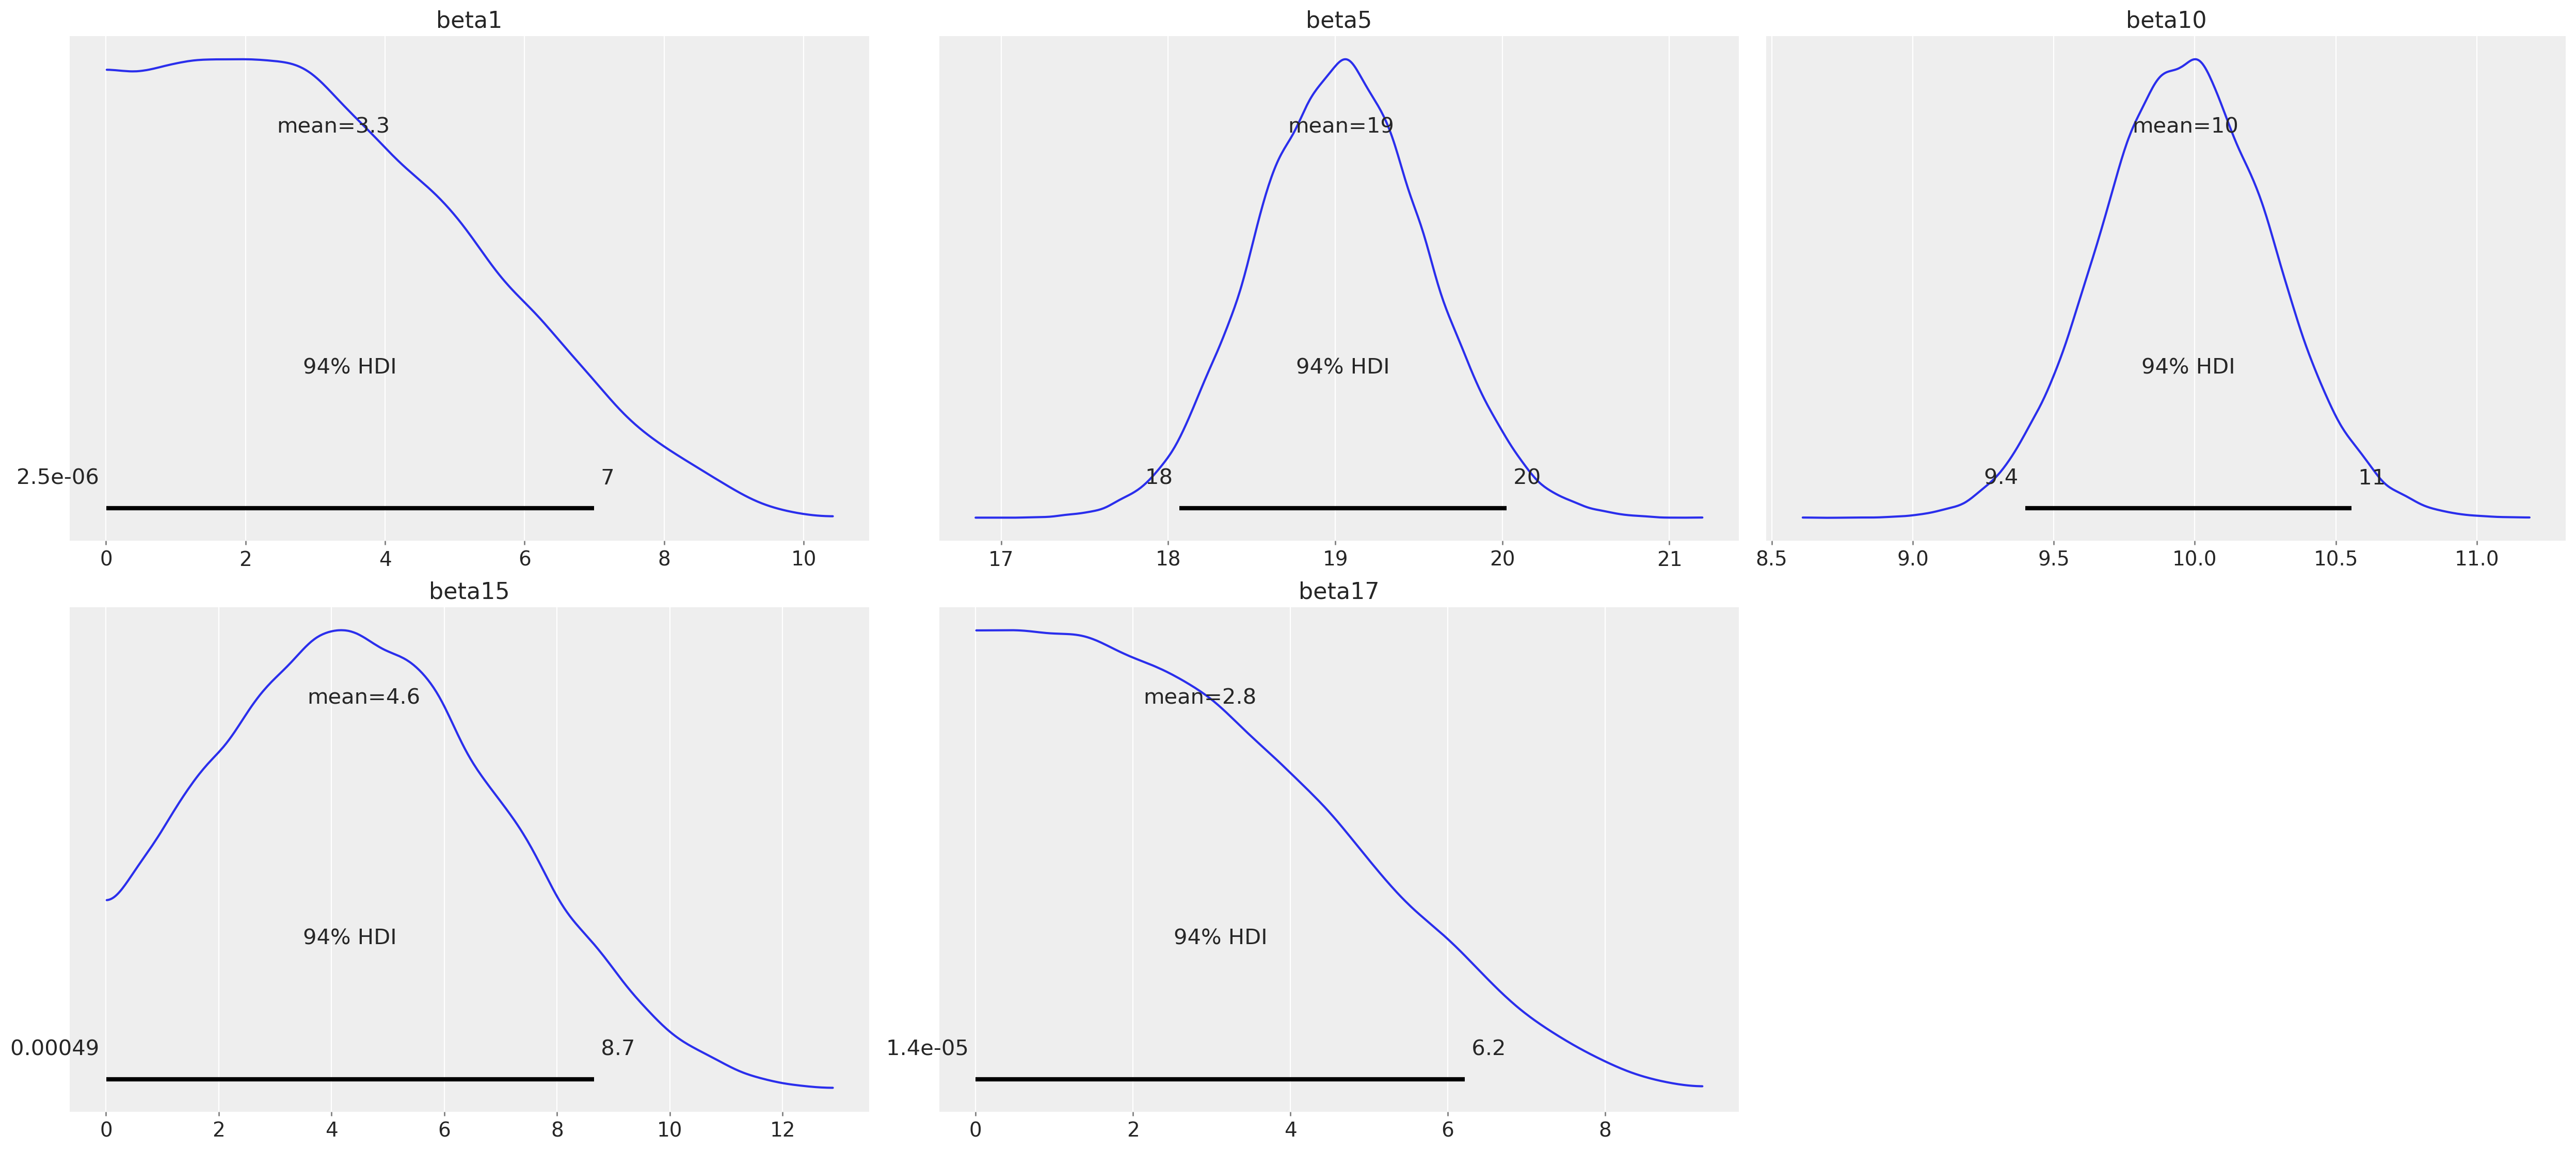

In [97]:
az.plot_posterior(trace_cle_pruned, var_names=betas1)